###### ETL Process: 
--> Import Python Package 
--> Connect to source database and define destination database in SQL server 
--> read csv file
--> concat existing data and new data
--> populate SQL table

In [1]:
import pandas as pd
import numpy as np
import os
file_path=r'C:\Users\nim\Documents\ZZZ-Data Analysis Training\Business_Data_Analysis\Bizdata Analytics workshop 1\Project_retail/'

In [2]:
import pyodbc
import urllib
import sqlalchemy

'''sources databases'''
params_p = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse1;"
                                 "UID=sa;"
                                 "PWD=Kyomichelle@user1")

engine_p = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_p))


params_s = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse2;"
                                 "UID=sa;"
                                 "PWD=Kyomichelle@user1")

engine_s = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_s))



'''destination databases'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=Kyomichelle@user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [3]:
df=pd.read_excel(file_path+'data - Promotional Effectiveness Analysis.xlsx')
df.head()


,Year,week number,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,# Transactions that contained the product
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379


In [4]:
df.shape,df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       134 non-null    int64  
 1   week number                                134 non-null    int64  
 2   Product                                    134 non-null    object 
 3   Price                                      134 non-null    float64
 4   On Flyer?                                  134 non-null    object 
 5   Discount                                   134 non-null    float64
 6   Units                                      134 non-null    int64  
 7   Sales $                                    134 non-null    float64
 8   Gross Margin $                             134 non-null    float64
 9   # Transactions that contained the product  134 non-null    int64  
dtypes: float64(4), int64(4), o

((134, 10), None)

In [5]:
df.to_sql('retail',engine_datahub,if_exists='replace',index=False)

In [6]:
# drop duplicates - no duplicates
df.drop_duplicates(keep='first', inplace=True)
df.shape

(134, 10)

In [7]:
df_new = df.rename({'# Transactions that contained the product':'Num_Transact','week number':'week'},axis=1)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379


In [8]:
df_new.describe()

,Year,week,Price,Discount,Units,Sales $,Gross Margin $,Num_Transact
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,2021.223881,22.358209,5.381045,0.168657,22475.373134,100484.140299,24477.665632,14527.977612
std,0.418407,15.500377,1.684358,0.175327,16891.686295,50213.865512,10730.292069,5824.488856
min,2021.000000,1.000000,2.490000,0.000000,8381.000000,47484.840000,-23932.000000,8216.000000
25%,2021.000000,9.000000,3.990000,0.000000,9701.000000,66589.775000,22974.742500,9261.250000
50%,2021.000000,19.000000,4.990000,0.150000,13118.000000,73012.860000,24993.375000,12071.000000
75%,2021.000000,35.750000,6.790000,0.300000,32441.750000,131230.107500,32921.070000,21111.000000
max,2022.000000,52.000000,7.990000,0.500000,77200.000000,232605.030000,35631.740000,26439.000000


In [9]:
df_new['Sales/Transact'] = df_new['Sales $']/df_new['Num_Transact']
df_new['Margin/Transact']= df_new['Gross Margin $']/df_new['Num_Transact']
df_new['Cost'] = (df['Sales $']-df['Gross Margin $'])/df['Units']
df_new

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.700000,8460,8.150556,3.968168,4.100000
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.770000,9983,7.436048,3.253909,4.100000
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.520000,17117,6.917586,1.751447,4.100000
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.510000,9038,7.714584,3.491647,4.100000
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.180000,8379,8.069147,3.928533,4.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2022,11,Aussie,4.29,Yes,0.15,14757,63307.53,22239.353931,12315,5.140685,1.805875,2.782962
130,2022,12,Aussie,4.99,No,0.00,10873,54256.27,23811.870000,10556,5.139851,2.255766,2.800000
131,2022,13,Aussie,4.49,Yes,0.10,12630,56708.70,21339.947228,11254,5.038982,1.896210,2.800376
132,2022,14,Aussie,4.99,No,0.00,10767,53727.33,23579.730000,10556,5.089743,2.233775,2.800000


In [10]:
df_new.groupby('Product')['Sales $'].max()

Product
Aussie     192228.00
Pantene    232605.03
Name: Sales $, dtype: float64

Discount
0.00    28
0.05     3
0.10     1
0.15     7
0.20     3
0.30     7
0.35     2
0.40     5
0.45     3
0.50     8
Name: week, dtype: int64

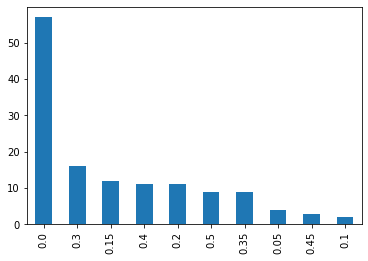

In [197]:
df_new['Discount'].value_counts().plot(kind='bar')
df_Pantene.groupby('Discount')['week'].count()

###### 1.What price point is most effective at maximizing sales?

In [13]:
df_Pantene = df_new.query("Product=='Pantene'")
df_Pantene.loc[df_Pantene['Sales $'].idxmax()]
# 3.99 which is 50% discount of the original price is the most effective price to maximize sales

Year                    2021
week                      12
Product              Pantene
Price                   3.99
On Flyer?                Yes
Discount                 0.5
Units                  58297
Sales $            232605.03
Gross Margin $      -6412.67
Num_Transact           26439
Sales/Transact        8.7978
Margin/Transact    -0.242546
Cost                     4.1
Name: 11, dtype: object

In [14]:
df_Aussie = df_new.query("Product=='Aussie'")
df_Aussie.loc[df_Aussie['Sales $'].idxmax()]
#2.49 which is 50% discount of the original price is the most effective price to maximize sales

Year                   2021
week                     39
Product              Aussie
Price                  2.49
On Flyer?               Yes
Discount                0.5
Units                 77200
Sales $            192228.0
Gross Margin $     -23932.0
Num_Transact          22396
Sales/Transact      8.58314
Margin/Transact   -1.068584
Cost                    2.8
Name: 105, dtype: object

###### 2.What price point is most effective at maximizing gross margin?

In [15]:
df_new.groupby('Product')['Gross Margin $'].max()

Product
Aussie     28248.22
Pantene    35631.74
Name: Gross Margin $, dtype: float64

In [16]:
df_Pantene.loc[df_Pantene['Gross Margin $'].idxmax()]
# 6.79 which is 15% discount of the original price is the most effective price point to maximize gross margin

Year                   2021
week                     35
Product             Pantene
Price                  6.79
On Flyer?               Yes
Discount               0.15
Units                 13246
Sales $            89940.34
Gross Margin $     35631.74
Num_Transact          12130
Sales/Transact     7.414702
Margin/Transact    2.937489
Cost                    4.1
Name: 34, dtype: object

In [17]:
df_Aussie.loc[df_Aussie['Gross Margin $'].idxmax()]
# 3.99 which is 20% discount of the original price is the most effective price point to maximize gross margin

Year                   2021
week                     18
Product              Aussie
Price                  3.99
On Flyer?               Yes
Discount                0.2
Units                 23738
Sales $            94714.62
Gross Margin $     28248.22
Num_Transact          17558
Sales/Transact     5.394385
Margin/Transact    1.608852
Cost                    2.8
Name: 84, dtype: object

###### 3.Is Shampoo seasonal (influenced by time of year)? Explain why or why not.

in this case, num of transactions might be more appropriate to use than sales units because Shampoo has several more brands, 
not only Aussie and Pantene.

step 1: convert week number into day then into month.
    
step 2: reasearch the correlation of discount and number of transactions and look at both trends.
    
If the monthly variation of number of transactions is the same with discount variation, then there is no seasonality.

In [18]:
from datetime import datetime, timedelta
df_new['Year'][0]
df_new['week'][0]
date = str(df_new['Year'][0]) + '-W' + str(df_new['week'][0])
res = datetime.strptime(date + '-1', "%Y-W%W-%w")
res

datetime.datetime(2021, 1, 4, 0, 0)

In [19]:
total_num = len(df_new['Year']) 
period = []
for i in range(total_num):
    df_new['Year'][i]
    df_new['week'][i]
    date = str(df_new['Year'][i]) + '-W' + str(df_new['week'][i])
    res = datetime.strptime(date + '-1', "%Y-W%W-%w")
    period.append(str(res))

df_new['Period'] = period
df_new['Period'] = df_new['Period'].apply(pd.to_datetime)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460,8.150556,3.968168,4.1,2021-01-04
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983,7.436048,3.253909,4.1,2021-01-11
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117,6.917586,1.751447,4.1,2021-01-18
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038,7.714584,3.491647,4.1,2021-01-25
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379,8.069147,3.928533,4.1,2021-02-01


In [20]:
from datetime import datetime
import datetime as dt
from datetime import date
def monthly(x):
    return dt.datetime(x.year,x.month, 1)

In [21]:
df_new['Month']= df_new['Period'].apply(monthly)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460,8.150556,3.968168,4.1,2021-01-04,2021-01-01
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983,7.436048,3.253909,4.1,2021-01-11,2021-01-01
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117,6.917586,1.751447,4.1,2021-01-18,2021-01-01
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038,7.714584,3.491647,4.1,2021-01-25,2021-01-01
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379,8.069147,3.928533,4.1,2021-02-01,2021-02-01


In [209]:
df_new_sales_trend_mon = df_new.groupby('Month').agg({'Num_Transact':'mean','Discount':'mean'})
df_new_sales_trend_mon

,Num_Transact,Discount
Month,,
2021-01-01,13192.000,0.13125
2021-02-01,14411.125,0.16250
2021-03-01,15849.400,0.19500
2021-04-01,12949.875,0.11250
2021-05-01,15945.800,0.21000
2021-06-01,15573.500,0.19375
2021-07-01,14534.250,0.17500
2021-08-01,15299.800,0.19500
2021-09-01,12841.875,0.13125


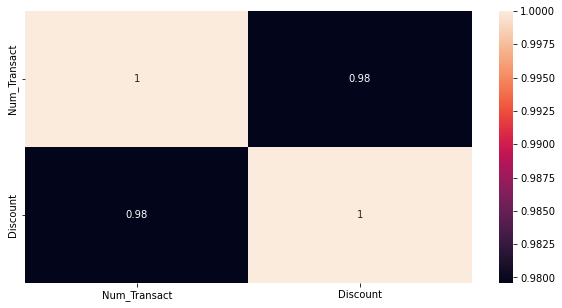

In [214]:
df_new_sales_trend_mon.corr()
corrMatrix = df_new_sales_trend_mon.corr()
plt.figure(figsize = (10,5))
ax=(sns.heatmap(corrMatrix, annot=True))
plt.show()
# The number of transactions and discount are strongly correlated

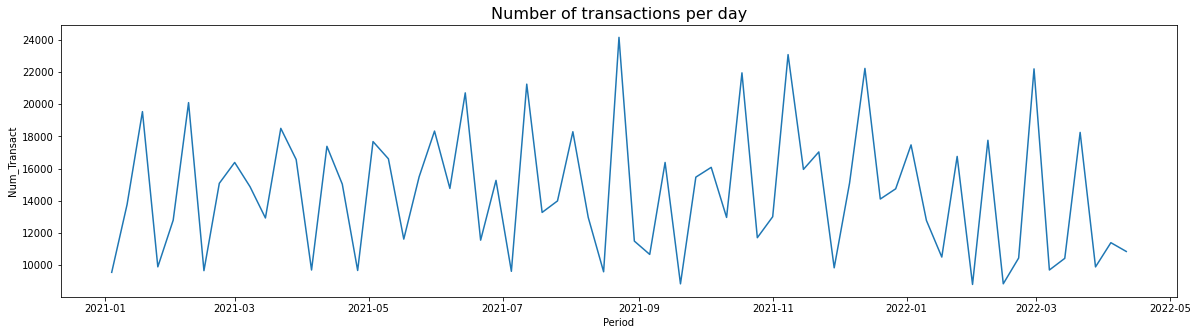

In [205]:
# no seasonality detected. continuous sales
import matplotlib.pyplot as plt 
import seaborn as sns
df_new_sales_trend_period = pd.DataFrame(df_new.groupby('Period')['Num_Transact'].sum())
plt.figure(figsize=(20,5))
sns.lineplot(x = df_new_sales_trend_period.index, y = df_new_sales_trend_period['Num_Transact'])
plt.title("Number of transactions per day",fontsize = 16)
plt.show()

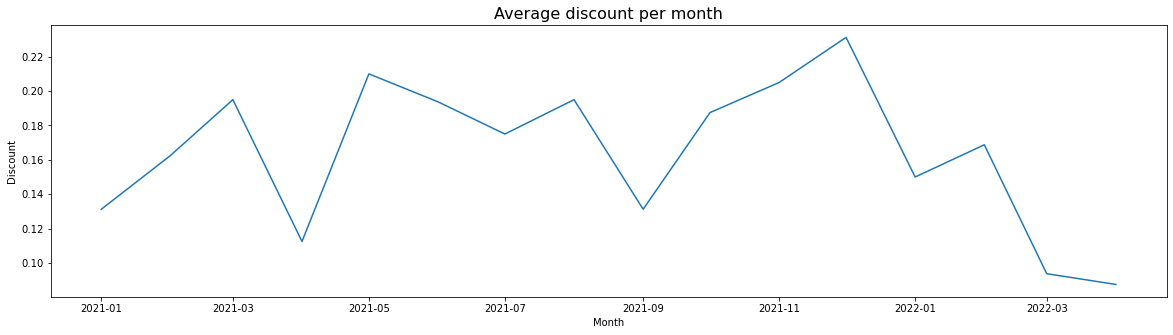

In [210]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(x = df_new_sales_trend_mon.index, y = df_new_sales_trend_mon['Discount'])
plt.title("Average discount per month",fontsize = 16)
plt.show()

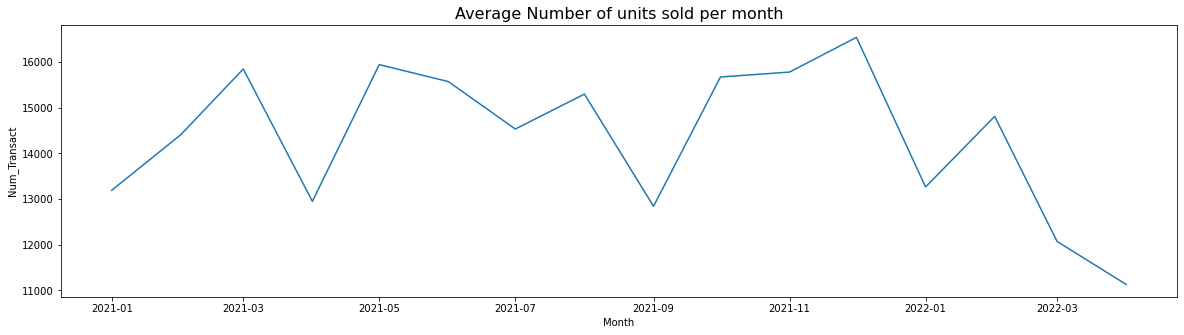

In [211]:
plt.figure(figsize=(20,5))
sns.lineplot(x = df_new_sales_trend_mon.index, y = df_new_sales_trend_mon['Num_Transact'])
plt.title("Average Number of Transactions per month",fontsize = 16)
plt.show()

###### Conclusion: the number of transactions decreases or increases in the same trend as discount rate. 
There's no obvious seasonality detected. It's continuous sales depending on discount rate.

###### 4.What is the cost per unit of each product?

In [27]:
pantene_cost = df_Pantene['Cost'][0]
df_new.groupby('Product')['Cost'].mean()
# Cost of Aussie is $2.8 each
# Cost of Pantene is $4.1 each

Product
Aussie     2.798734
Pantene    4.100000
Name: Cost, dtype: float64

In [70]:
Pantene_orginal_price = df_Pantene.query("Discount==0")['Price'].mean()
Pantene_margin = Pantene_orginal_price - pantene_cost 
print('Pantene_margin is {}:'.format(Pantene_margin))

Pantene_margin is 3.8900000000000032:


In [74]:
Aussie_orignal_price = df_Aussie.query("Discount==0")['Price'].mean()
Aussie_cost = df_Aussie['Cost'].mean()
Aussie_margin = Aussie_orignal_price - Aussie_cost
print('Aussie_margin is {}:'.format(Aussie_margin))

Aussie_margin is 2.1912658464915364:


###### 5.How would Pantene perform for units, sales and margin with a 25% discount?¶

Step1: calculate profit % = profit/sales = (price – cost)/price at 25% discount and at 60% discount
Pantene price = 7.99, cost = 4.1, profit = 3.89
The profit rate at 25% is 32%. The profit rate at 60% is -28%


Step 2: calculate the average units sold at 25% = (average units sold at 20% + average units sold at 30%)/2. Here it should use average value instead of total value because the units sold is strongly correlated with discounts, but discounts vary over the periods.

    
Step3: calculate the average number of transactions and average sales per transaction at 25% discount, same approach as the average units sold at 25% . Then average sales = average number of transactions x average sales per transaction. Average margin = average sales x 32%


In [80]:
pantene_25_price = Pantene_orginal_price*(1-0.25)
pantene_25_profit_percentage = (pantene_25_price-pantene_cost)/pantene_25_price
print('Pantene profit divided by sales at 25% discount is {}:'.format(pantene_25_profit_percentage))

Pantene profit divided by sales at 25% discount is 0.3158114309553612:


In [82]:
pantene_60_price = Pantene_orginal_price*(1-0.6)
pantene_60_profit_percentage = (pantene_60_price-pantene_cost)/pantene_60_price
print('Pantene profit divided by sales at 60% discount is {}:'.format(pantene_60_profit_percentage))

Pantene profit divided by sales at 60% discount is -0.2828535669586977:


In [28]:
df_Pantene_20 = df_Pantene.query("Discount == 0.2")
df_Pantene_30 = df_Pantene.query("Discount == 0.3")
df_Pantene_20_30 = pd.concat([df_Pantene_20,df_Pantene_30])
df_Pantene_20_30

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost
19,2021,20,Pantene,6.49,Yes,0.2,14099,91502.51,33696.61,12691,7.210032,2.655158,4.1
28,2021,29,Pantene,6.49,Yes,0.2,14378,93313.22,34363.42,12691,7.352708,2.707700,4.1
42,2021,43,Pantene,6.49,Yes,0.2,14239,92411.11,34031.21,12447,7.424368,2.734089,4.1
2,2021,3,Pantene,5.49,Yes,0.3,21568,118408.32,29979.52,17117,6.917586,1.751447,4.1
17,2021,18,Pantene,5.49,Yes,0.3,21995,120752.55,30573.05,17795,6.785757,1.718070,4.1
29,2021,30,Pantene,5.49,Yes,0.3,21363,117282.87,29694.57,17117,6.851836,1.734800,4.1
30,2021,31,Pantene,5.49,No,0.3,18339,100681.11,25491.21,14838,6.785356,1.717968,4.1
50,2021,51,Pantene,5.49,Yes,0.3,21576,118452.24,29990.64,17456,6.785761,1.718071,4.1
52,2022,1,Pantene,5.49,Yes,0.3,21157,116151.93,29408.23,17117,6.785764,1.718072,4.1
53,2022,2,Pantene,5.49,No,0.3,18338,100675.62,25489.82,14694,6.851478,1.734709,4.1


In [34]:
#Pantene's performance on units, sales, gross margin at 25% of discount
# Option 1 - the total units, sales, gross margins of 20% and 30% then divided by 2
#this approach is NOT correct because the number of discounts are different.
def sum_variable(df,x):
    print(df.groupby('Product')[x].sum()/2)
pantene_attribute = ['Units','Sales $','Gross Margin $']
sum_variable(df_Pantene_20_30,pantene_attribute)

           Units    Sales $  Gross Margin $
Product                                    
Pantene  93526.0  534815.74       151359.14


In [35]:
def mean_variable(df,x):
    print(df.groupby('Discount')[x].mean())
pantene_attribute2 = ['Units','Num_Transact','Sales/Transact','Margin/Transact']
mean_variable(df_Pantene,pantene_attribute2)

                 Units  Num_Transact  Sales/Transact  Margin/Transact
Discount                                                             
0.00       8636.214286   8396.392857        8.218387         4.001192
0.05       9371.000000   9127.333333        7.689710         3.480390
0.10      10183.000000   9983.000000        7.436048         3.253909
0.15      12882.571429  11833.428571        7.394484         2.929479
0.20      14238.666667  12609.666667        7.329036         2.698982
0.30      20619.428571  16590.571429        6.823363         1.727591
0.35      27942.000000  21494.000000        6.876951         1.546989
0.40      32604.600000  22379.400000        6.978616         1.005270
0.45      41056.333333  23154.666667        7.963820         0.691735
0.50      56170.875000  25998.125000        8.619854        -0.237640


In [36]:
def sum_variable2(df,x):
    print(df.groupby('Discount')[x].sum())
sum_variable2(df_Pantene,pantene_attribute2)

           Units  Num_Transact  Sales/Transact  Margin/Transact
Discount                                                       
0.00      241814        235099      230.114834       112.033380
0.05       28113         27382       23.069130        10.441169
0.10       10183          9983        7.436048         3.253909
0.15       90178         82834       51.761385        20.506351
0.20       42716         37829       21.987108         8.096947
0.30      144336        116134       47.763538        12.093136
0.35       55884         42988       13.753902         3.093978
0.40      163023        111897       34.893079         5.026352
0.45      123169         69464       23.891461         2.075205
0.50      449367        207985       68.958832        -1.901121


In [37]:
df_Pantene_avg_unit = pd.DataFrame(df_Pantene.groupby('Discount')['Units'].mean())
df_Pantene_avg_unit

,Units
Discount,
0.00,8636.214286
0.05,9371.000000
0.10,10183.000000
0.15,12882.571429
0.20,14238.666667
0.30,20619.428571
0.35,27942.000000
0.40,32604.600000
0.45,41056.333333


In [38]:
df_Pantene_avg_transact = pd.DataFrame(df_Pantene.groupby('Discount')['Num_Transact'].mean())
Pantene_20_transact = df_Pantene_avg_transact['Num_Transact'][df_Pantene_avg_transact['Num_Transact'].index ==0.20].to_list()[0]
Pantene_30_transact = df_Pantene_avg_transact['Num_Transact'][df_Pantene_avg_transact['Num_Transact'].index ==0.30].to_list()[0]
Pantene_25_transact = (Pantene_20_transact + Pantene_30_transact)/2
Pantene_25_transact

14600.119047619046

In [39]:
#Option2 check data using average value
pantene_25 = {}
pantene_attribute2 = ['Units','Num_Transact','Sales/Transact','Margin/Transact']
len(pantene_attribute2)
for x in pantene_attribute2:
    df_Pantene_avg = pd.DataFrame(df_Pantene.groupby('Discount')[x].mean())
    Pantene_20_avg= df_Pantene_avg[x][df_Pantene_avg[x].index==0.2].to_list()[0]
    Pantene_30_avg = df_Pantene_avg[x][df_Pantene_avg[x].index==0.3].to_list()[0]
    Pantene_25_avg = (Pantene_20_avg + Pantene_30_avg)/2
    pantene_25[x]=Pantene_25_avg
print(pantene_25)


{'Units': 17429.04761904762, 'Num_Transact': 14600.119047619046, 'Sales/Transact': 7.076199267339493, 'Margin/Transact': 2.213286656880737}


In [83]:
pantene_25_sales = pantene_25['Num_Transact']*pantene_25['Sales/Transact']
pantene_25_margin = pantene_25_sales * pantene_25_profit_percentage
pantene_25_dict2 = {'Sales $':pantene_25_sales,'Gross Margin $':pantene_25_margin}
print(pantene_25_dict2)
pantene_25_dict2.update(pantene_25)
print(pantene_25_dict2)


{'Sales $': 103313.35170783126, 'Gross Margin $': 32627.537439644697}
{'Sales $': 103313.35170783126, 'Gross Margin $': 32627.537439644697, 'Units': 17429.04761904762, 'Num_Transact': 14600.119047619046, 'Sales/Transact': 7.076199267339493, 'Margin/Transact': 2.213286656880737}


In [84]:
#Pantene's performance on units, sales, gross margin at 25% of discount
df_pantene_25_data = pd.DataFrame(pantene_25_dict2,index  = [1,2,3,4,5])
df_pantene_25_data.head(1)

,Sales $,Gross Margin $,Units,Num_Transact,Sales/Transact,Margin/Transact
1,103313.351708,32627.53744,17429.047619,14600.119048,7.076199,2.213287


In [85]:
pantene_25_dict2['Discount'] = 0.25
from collections import OrderedDict
key_order= ['Discount', 'Sales $', 'Gross Margin $', 'Units', 'Num_Transact','Sales/Transact','Margin/Transact']
d= OrderedDict(pantene_25_dict2)
for k in key_order: 
    d.move_to_end(k)
print(d)

OrderedDict([('Discount', 0.25), ('Sales $', 103313.35170783126), ('Gross Margin $', 32627.537439644697), ('Units', 17429.04761904762), ('Num_Transact', 14600.119047619046), ('Sales/Transact', 7.076199267339493), ('Margin/Transact', 2.213286656880737)])


###### 6.How would Pantene perform for units, sales and margin with a 60% discount?

To calculate the performance of Pantene at 60% discount

Step1: Select the rows with discount rate changes at 10%, drop the rows with discount rate changes at 5%

Step2: Calculate growth rate and growth delta row over row

Step3: Average units at 60% discount = average units at 50% of discount x (1 + average unit growth rate), same approach for average number of transactions and average sales per transactions. Then average sales = average number of transactions x average sales per transaction. Average margin = average sales x -28%


In [91]:
df_Pantene_avg_data = pd.DataFrame(df_Pantene.groupby('Discount')[['Sales $', 'Gross Margin $','Units','Num_Transact','Sales/Transact','Margin/Transact']].mean()).reset_index()
df_Pantene_avg_data.columns

Index(['Discount', 'Sales $', 'Gross Margin $', 'Units', 'Num_Transact',
       'Sales/Transact', 'Margin/Transact'],
      dtype='object')

In [118]:
df_Pantene_avg_data_incomplete = df_Pantene_avg_data.drop(index = 6,axis=0)
df_Pantene_avg_data_incomplete['sequence_index'] = [0,0,1,1,2,2,3,3,4]
df_Pantene_avg_data_incomplete

,Discount,Sales $,Gross Margin $,Units,Num_Transact,Sales/Transact,Margin/Transact,sequence_index
0,0.00,69003.352143,33594.873571,8636.214286,8396.392857,8.218387,4.001192,0
1,0.05,70188.790000,31767.690000,9371.000000,9127.333333,7.689710,3.480390,0
2,0.10,74234.070000,32483.770000,10183.000000,9983.000000,7.436048,3.253909,1
3,0.15,87472.660000,34654.117143,12882.571429,11833.428571,7.394484,2.929479,1
4,0.20,92408.946667,34030.413333,14238.666667,12609.666667,7.329036,2.698982,2
5,0.30,113200.662857,28661.005714,20619.428571,16590.571429,6.823363,1.727591,2
7,0.40,156176.034000,22497.174000,32604.600000,22379.400000,6.978616,1.005270,3
8,0.45,184342.936667,16011.970000,41056.333333,23154.666667,7.963820,0.691735,3
9,0.50,224121.791250,-6178.796250,56170.875000,25998.125000,8.619854,-0.237640,4


In [120]:
df_Pantene_avg_data_incomplete2 = df_Pantene_avg_data_incomplete[['Discount', 'Sales $', 'Gross Margin $', 'Units', 'Num_Transact',
       'Sales/Transact', 'Margin/Transact','sequence_index']][::2].set_index('sequence_index')
df_Pantene_avg_data_incomplete2

,Discount,Sales $,Gross Margin $,Units,Num_Transact,Sales/Transact,Margin/Transact
sequence_index,,,,,,,
0,0.0,69003.352143,33594.873571,8636.214286,8396.392857,8.218387,4.001192
1,0.1,74234.070000,32483.770000,10183.000000,9983.000000,7.436048,3.253909
2,0.2,92408.946667,34030.413333,14238.666667,12609.666667,7.329036,2.698982
3,0.4,156176.034000,22497.174000,32604.600000,22379.400000,6.978616,1.005270
4,0.5,224121.791250,-6178.796250,56170.875000,25998.125000,8.619854,-0.237640


In [132]:
df_Pantene_avg_data_incomplete2['Units'][1]-df_Pantene_avg_data_incomplete2['Units'][0]

0.17910460105701068

In [138]:
def growth_rate(a):
    sales_growth_rate = [0,]
    for p1 in range(4):
        p2 = (df_Pantene_avg_data_incomplete2[a][p1+1]-df_Pantene_avg_data_incomplete2[a][p1])/df_Pantene_avg_data_incomplete2[a][p1]
        sales_growth_rate.append(p2)
    return sales_growth_rate

In [140]:
def growth_delta(b):
    sales_delta = [0,]
    for p1 in range(4):
        p2 = df_Pantene_avg_data_incomplete2[b][p1+1]-df_Pantene_avg_data_incomplete2[b][p1]
        sales_delta.append(p2)
    return sales_delta

In [139]:
growth_rate('Units')

[0,
 0.17910460105701068,
 0.39827817604504234,
 1.28986328307894,
 0.7227898824092307]

In [141]:
new_attributes1 = []
new_attributes2 = []
for m in ['Units', 'Num_Transact','Sales/Transact','Margin/Transact']:
    new_attributes1.append(growth_rate(m))
    new_attributes2.append(growth_delta(m))
print(new_attributes1) 
print(new_attributes2)


[[0, 0.17910460105701068, 0.39827817604504234, 1.28986328307894, 0.7227898824092307], [0, 0.1889629475242345, 0.2631139603993455, 0.7747812524782576, 0.16169892847886888], [0, -0.09519369674085294, -0.014391021342101448, -0.04781259741551272, 0.2351810733594722], [0, -0.18676520859650447, -0.1705414263538102, -0.6275372850068051, -1.2363942129065788]]
[[0, 1546.7857142857138, 4055.666666666666, 18365.933333333334, 23566.275], [0, 1586.6071428571431, 2626.666666666666, 9769.733333333335, 3618.7249999999985], [0, -0.7823386315555751, -0.10701232952830342, -0.35042024544315087, 1.6412383325609508], [0, -0.7472834822177314, -0.5549262214914465, -1.6937121021388633, -1.2429104073723383]]


In [143]:
df_Pantene_avg_data_incomplete2['Unit_growth_rate']=new_attributes1[0]
df_Pantene_avg_data_incomplete2['Num_Transact_growth_rate']=new_attributes1[1]
df_Pantene_avg_data_incomplete2['Sales/Transact_growth_rate']= new_attributes1[2]
df_Pantene_avg_data_incomplete2['Margin/Transact_growth_rate']= new_attributes1[3]
df_Pantene_avg_data_incomplete2['Unit_growth_delta'] = new_attributes2[0]
df_Pantene_avg_data_incomplete2['Num_Transact_growth_delta']=new_attributes2[1]
df_Pantene_avg_data_incomplete2['Sales/Transact_growth_delta'] = new_attributes2[2]
df_Pantene_avg_data_incomplete2['Margin/Transact_growth_delta'] = new_attributes2[3]
df_Pantene_avg_data_incomplete2

,Discount,Sales $,Gross Margin $,Units,Num_Transact,Sales/Transact,Margin/Transact,Unit_growth_rate,Num_Transact_growth_rate,Sales/Transact_growth_rate,Margin/Transact_growth_rate,Unit_growth_delta,Num_Transact_growth_delta,Sales/Transact_growth_delta,Margin/Transact_growth_delta
sequence_index,,,,,,,,,,,,,,,
0,0.0,69003.352143,33594.873571,8636.214286,8396.392857,8.218387,4.001192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.1,74234.070000,32483.770000,10183.000000,9983.000000,7.436048,3.253909,0.179105,0.188963,-0.095194,-0.186765,1546.785714,1586.607143,-0.782339,-0.747283
2,0.2,92408.946667,34030.413333,14238.666667,12609.666667,7.329036,2.698982,0.398278,0.263114,-0.014391,-0.170541,4055.666667,2626.666667,-0.107012,-0.554926
3,0.4,156176.034000,22497.174000,32604.600000,22379.400000,6.978616,1.005270,1.289863,0.774781,-0.047813,-0.627537,18365.933333,9769.733333,-0.350420,-1.693712
4,0.5,224121.791250,-6178.796250,56170.875000,25998.125000,8.619854,-0.237640,0.722790,0.161699,0.235181,-1.236394,23566.275000,3618.725000,1.641238,-1.242910


In [144]:
df_Pantene_avg_data_incomplete3 = df_Pantene_avg_data_incomplete2.drop(index=0,axis=0)
df_Pantene_avg_data_incomplete3

,Discount,Sales $,Gross Margin $,Units,Num_Transact,Sales/Transact,Margin/Transact,Unit_growth_rate,Num_Transact_growth_rate,Sales/Transact_growth_rate,Margin/Transact_growth_rate,Unit_growth_delta,Num_Transact_growth_delta,Sales/Transact_growth_delta,Margin/Transact_growth_delta
sequence_index,,,,,,,,,,,,,,,
1,0.1,74234.070000,32483.770000,10183.000000,9983.000000,7.436048,3.253909,0.179105,0.188963,-0.095194,-0.186765,1546.785714,1586.607143,-0.782339,-0.747283
2,0.2,92408.946667,34030.413333,14238.666667,12609.666667,7.329036,2.698982,0.398278,0.263114,-0.014391,-0.170541,4055.666667,2626.666667,-0.107012,-0.554926
3,0.4,156176.034000,22497.174000,32604.600000,22379.400000,6.978616,1.005270,1.289863,0.774781,-0.047813,-0.627537,18365.933333,9769.733333,-0.350420,-1.693712
4,0.5,224121.791250,-6178.796250,56170.875000,25998.125000,8.619854,-0.237640,0.722790,0.161699,0.235181,-1.236394,23566.275000,3618.725000,1.641238,-1.242910


In [145]:
df_Pantene_avg_data_incomplete3['Unit_growth_rate'].mean()

0.647508985647556

In [149]:
pantene_60_units = df_Pantene_avg_data_incomplete3['Units'][4] * (1+ df_Pantene_avg_data_incomplete3['Unit_growth_rate'].mean())
pantene_60_units

92542.02129418566

In [150]:
pantene_60_num_transact = df_Pantene_avg_data_incomplete3['Num_Transact'][4] * (1+ df_Pantene_avg_data_incomplete3['Num_Transact_growth_rate'].mean())
pantene_60_num_transact

35023.09519158918

In [151]:
pantene_60_sales_per_transact = df_Pantene_avg_data_incomplete3['Sales/Transact'][4] * (1+ df_Pantene_avg_data_incomplete3['Sales/Transact_growth_rate'].mean())
pantene_60_sales_per_transact

8.787475199523739

In [167]:
pantene_60_sales = pantene_60_num_transact * pantene_60_sales_per_transact #Num_Transact x Sales/Transact = Sales
pantene_60_gross_margin = pantene_60[3]*pantene_60_profit_percentage # Gross Margin = Sales * pantene_60_profit %
pantene_60_margin_per_transact = pantene_60_gross_margin/pantene_60_num_transact

In [168]:
pantene_60_dict = {'Discount':0.6,'Sales $':pantene_60_sales,'Gross Margin $':pantene_60_gross_margin,'Units':pantene_60_units,'Num_Transact':pantene_60_num_transact,'Sales/Transact':pantene_60_sales_per_transact,'Margin/Transact':pantene_60_margin_per_transact}
pantene_60_data = pd.DataFrame(pantene_60_dict,index = [1,2,3,4,5,6,7])
pantene_60_data.head(1)

,Discount,Sales $,Gross Margin $,Units,Num_Transact,Sales/Transact,Margin/Transact
1,0.6,307764.580407,-87052.309352,92542.021294,35023.095192,8.787475,-2.485569


In [169]:
df_Pantene_summary = df_Pantene.groupby('Discount').agg({'Sales $':'mean','Gross Margin $':'mean','Units':'mean','Num_Transact':'mean','Sales/Transact':'mean','Margin/Transact':'mean'})
df_Pantene_summary['Sequence'] = [1,2,3,4,5,6,7,8,9,10]
df_Pantene_summary = df_Pantene_summary.reset_index()
df_Pantene_summary.set_index('Sequence',inplace = True)
df_Pantene_summary

,Discount,Sales $,Gross Margin $,Units,Num_Transact,Sales/Transact,Margin/Transact
Sequence,,,,,,,
1,0.00,69003.352143,33594.873571,8636.214286,8396.392857,8.218387,4.001192
2,0.05,70188.790000,31767.690000,9371.000000,9127.333333,7.689710,3.480390
3,0.10,74234.070000,32483.770000,10183.000000,9983.000000,7.436048,3.253909
4,0.15,87472.660000,34654.117143,12882.571429,11833.428571,7.394484,2.929479
5,0.20,92408.946667,34030.413333,14238.666667,12609.666667,7.329036,2.698982
6,0.30,113200.662857,28661.005714,20619.428571,16590.571429,6.823363,1.727591
7,0.35,147813.180000,33250.980000,27942.000000,21494.000000,6.876951,1.546989
8,0.40,156176.034000,22497.174000,32604.600000,22379.400000,6.978616,1.005270
9,0.45,184342.936667,16011.970000,41056.333333,23154.666667,7.963820,0.691735


In [170]:
df_Pantene_summary1 = df_Pantene_summary.append(pantene_60_data.head(1))

In [171]:
df_Pantene_summary2 = df_Pantene_summary1.append(df_pantene_25_data.head(1))

In [172]:
df_Pantene_summary2.fillna(0.25,inplace = True)

In [173]:
df_Pantene_summary2['Sequence']= [1,2,3,4,5,7,8,9,10,11,12,6]
df_Pantene_summary3 = df_Pantene_summary2.sort_values(by='Sequence')
df_Pantene_summary3

,Discount,Sales $,Gross Margin $,Units,Num_Transact,Sales/Transact,Margin/Transact,Sequence
1,0.00,69003.352143,33594.873571,8636.214286,8396.392857,8.218387,4.001192,1
2,0.05,70188.790000,31767.690000,9371.000000,9127.333333,7.689710,3.480390,2
3,0.10,74234.070000,32483.770000,10183.000000,9983.000000,7.436048,3.253909,3
4,0.15,87472.660000,34654.117143,12882.571429,11833.428571,7.394484,2.929479,4
5,0.20,92408.946667,34030.413333,14238.666667,12609.666667,7.329036,2.698982,5
1,0.25,103313.351708,32627.537440,17429.047619,14600.119048,7.076199,2.213287,6
6,0.30,113200.662857,28661.005714,20619.428571,16590.571429,6.823363,1.727591,7
7,0.35,147813.180000,33250.980000,27942.000000,21494.000000,6.876951,1.546989,8
8,0.40,156176.034000,22497.174000,32604.600000,22379.400000,6.978616,1.005270,9
9,0.45,184342.936667,16011.970000,41056.333333,23154.666667,7.963820,0.691735,10


In [174]:
df_Pantene_summary4 = df_Pantene_summary3.set_index('Sequence')

In [175]:
df_Pantene_summary_avg = df_Pantene_summary4.rename(columns ={'Sales $':'Avg_Sales','Gross Margin $':'Avg_Margin','Units':'Avg_Units','Sales/Transact':'Avg_Sales/Transact','Margin/Transact':'Avg_Margin/Transact'})
df_Pantene_summary_avg

,Discount,Avg_Sales,Avg_Margin,Avg_Units,Num_Transact,Avg_Sales/Transact,Avg_Margin/Transact
Sequence,,,,,,,
1,0.00,69003.352143,33594.873571,8636.214286,8396.392857,8.218387,4.001192
2,0.05,70188.790000,31767.690000,9371.000000,9127.333333,7.689710,3.480390
3,0.10,74234.070000,32483.770000,10183.000000,9983.000000,7.436048,3.253909
4,0.15,87472.660000,34654.117143,12882.571429,11833.428571,7.394484,2.929479
5,0.20,92408.946667,34030.413333,14238.666667,12609.666667,7.329036,2.698982
6,0.25,103313.351708,32627.537440,17429.047619,14600.119048,7.076199,2.213287
7,0.30,113200.662857,28661.005714,20619.428571,16590.571429,6.823363,1.727591
8,0.35,147813.180000,33250.980000,27942.000000,21494.000000,6.876951,1.546989
9,0.40,156176.034000,22497.174000,32604.600000,22379.400000,6.978616,1.005270


###### Overview of Pantene on 25% discount and 60% discount

###### 7.What impact does being “On Flyer” have on performance?

On flyer can increase sales units and number of transactions but reduce gross margins

In [176]:
df_new_onflyer = df_new.groupby('On Flyer?')['Units','Sales $','Gross Margin $'].sum()
df_new_onflyer

C:\Users\nim\AppData\Local\Temp/ipykernel_29324/1344346986.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new_onflyer = df_new.groupby('On Flyer?')['Units','Sales $','Gross Margin $'].sum()


,Units,Sales $,Gross Margin $
On Flyer?,,,
No,861550,4720937.1,1.883077e+06
Yes,2150150,8743937.7,1.396930e+06


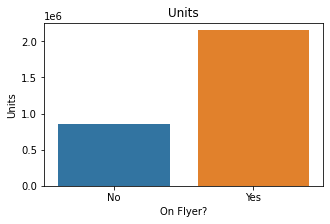

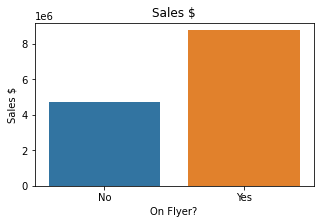

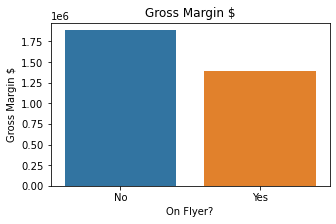

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
list_attribute = ['Units','Sales $','Gross Margin $']
for v in list_attribute:
    plt.figure(figsize = (5,3))
    sns.barplot(x=df_new_onflyer.index,y = v, data =df_new_onflyer)
    plt.title(v)
    plt.show()

###### 8.	Client wants to change the price on an upcoming Aussie Shampoo flyer promotion. Her goal is to maximize sales, but she does not want to sacrifice too much margin.

In [178]:
df_Aussi_right_discount = df_Aussie.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean()
df_Aussi_right_discount

C:\Users\nim\AppData\Local\Temp/ipykernel_29324/2521380085.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_Aussi_right_discount = df_Aussie.groupby('Discount')['Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean()


,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
Discount,,,,,,
0.00,10909.344828,54437.630690,23891.465172,10565.137931,5.153468,2.261742
0.05,11529.000000,55223.910000,22942.710000,11303.000000,4.885775,2.029789
0.10,12630.000000,56708.700000,21339.947228,11254.000000,5.038982,1.896210
0.15,15437.000000,66224.730000,23264.139503,12631.800000,5.242500,1.841642
0.20,22397.750000,89367.022500,26653.322500,16567.625000,5.402718,1.611337
0.30,35649.555556,124416.948889,24598.193333,20152.666667,6.186040,1.223028
0.35,46487.714286,152944.580000,22778.980000,20435.571429,7.490591,1.115620
0.40,57093.333333,170709.066667,10847.733333,22281.500000,7.661899,0.486877
0.50,77200.000000,192228.000000,-23932.000000,22396.000000,8.583140,-1.068584


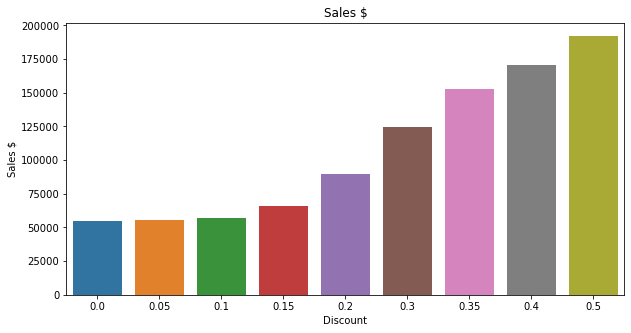

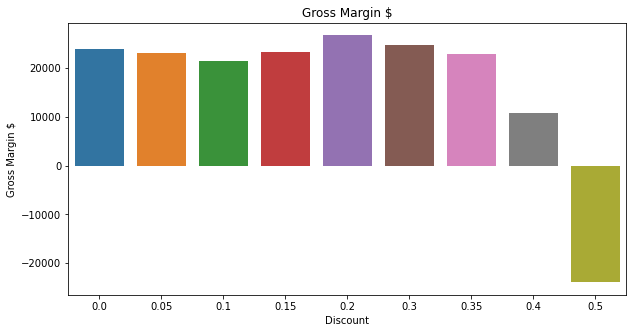

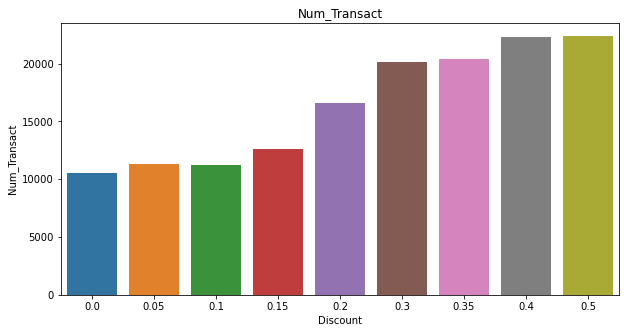

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
list_attribute = ['Sales $','Gross Margin $','Num_Transact']
for v in list_attribute:
    plt.figure(figsize = (10,5))
    sns.barplot(x=df_Aussi_right_discount.index,y = v, data =df_Aussi_right_discount)
    plt.title(v)
    plt.show()

###### Conclusion: If Aussie is on the flyer for promotion, to have maximize sales and not sacrifice margin, 40% discount should be chosen

In [180]:
price = df_Aussie.query("Discount==0.4")['Price'].mean()
description = "Price of Aussie at 40% discount is at: "
print(f'{description}{price}')

Price of Aussie at 40% discount is at: 2.99


###### Aussie Shampoo sold at $2.49 is a “loss leader” promotion. We lose money selling it at this price, but hope that people who came to buy it will purchase other items.

In [181]:
df_Aussi_right_discount.query("Discount==0.5")

,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
Discount,,,,,,
0.5,77200.0,192228.0,-23932.0,22396.0,8.58314,-1.068584


In [182]:
df_new_2 = df_new.groupby(['Discount','Product'])['Price','Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean()
df_new_2.sort_values(by='Num_Transact',ascending=False)
#Aussie sold at $2.49 has number of transactions ranked the 3rd.

C:\Users\nim\AppData\Local\Temp/ipykernel_29324/1284340119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new_2 = df_new.groupby(['Discount','Product'])['Price','Units','Sales $','Gross Margin $','Num_Transact','Sales/Transact','Margin/Transact'].mean()


Price         Units        Sales $  Gross Margin $  \
Discount Product                                                       
0.50     Pantene   3.99  56170.875000  224121.791250    -6178.796250   
0.45     Pantene   4.49  41056.333333  184342.936667    16011.970000   
0.50     Aussie    2.49  77200.000000  192228.000000   -23932.000000   
0.40     Pantene   4.79  32604.600000  156176.034000    22497.174000   
         Aussie    2.99  57093.333333  170709.066667    10847.733333   
0.35     Pantene   5.29  27942.000000  147813.180000    33250.980000   
         Aussie    3.29  46487.714286  152944.580000    22778.980000   
0.30     Aussie    3.49  35649.555556  124416.948889    24598.193333   
         Pantene   5.49  20619.428571  113200.662857    28661.005714   
0.20     Aussie    3.99  22397.750000   89367.022500    26653.322500   
0.15     Aussie    4.29  15437.000000   66224.730000    23264.139503   
0.20     Pantene   6.49  14238.666667   92408.946667    34030.413333   
0.15     Pantene   6.79  12882.571429   87472.660000    34654.117143   
0.05     Aussie    4.79  11529.000000   55223.910000    22942.710000   
0.10     Aussie    4.49  12630.000000   56708.700000    21339.947228   
0.00     Aussie    4.99  10909.344828   54437.630690    23891.465172   
0.10     Pantene   7.29  10183.000000   74234.070000    32483.770000   
0.05     Pantene   7.49   9371.000000   70188.790000    31767.690000   
0.00     Pantene   7.99   8636.214286   69003.352143    33594.873571   

                  Num_Transact  Sales/Transact  Margin/Transact  
Discount Product                                                 
0.50     Pantene  25998.125000        8.619854        -0.237640  
0.45     Pantene  23154.666667        7.963820         0.691735  
0.50     Aussie   22396.000000        8.583140        -1.068584  
0.40     Pantene  22379.400000        6.978616         1.005270  
         Aussie   22281.500000        7.661899         0.486877  
0.35     Pantene  21494.000000        6.876951         1.546989  
         Aussie   20435.571429        7.490591         1.115620  
0.30     Aussie   20152.666667        6.186040         1.223028  
         Pantene  16590.571429        6.823363         1.727591  
0.20     Aussie   16567.625000        5.402718         1.611337  
0.15     Aussie   12631.800000        5.242500         1.841642  
0.20     Pantene  12609.666667        7.329036         2.698982  
0.15     Pantene  11833.428571        7.394484         2.929479  
0.05     Aussie   11303.000000        4.885775         2.029789  
0.10     Aussie   11254.000000        5.038982         1.896210  
0.00     Aussie   10565.137931        5.153468         2.261742  
0.10     Pantene   9983.000000        7.436048         3.253909  
0.05     Pantene   9127.333333        7.689710         3.480390  
0.00     Pantene   8396.392857        8.218387         4.001192

In [183]:
df_new_2.sort_values(by='Sales $',ascending=False)
#Aussie sold at $2.49 has sales ranked the 2nd

Price         Units        Sales $  Gross Margin $  \
Discount Product                                                       
0.50     Pantene   3.99  56170.875000  224121.791250    -6178.796250   
         Aussie    2.49  77200.000000  192228.000000   -23932.000000   
0.45     Pantene   4.49  41056.333333  184342.936667    16011.970000   
0.40     Aussie    2.99  57093.333333  170709.066667    10847.733333   
         Pantene   4.79  32604.600000  156176.034000    22497.174000   
0.35     Aussie    3.29  46487.714286  152944.580000    22778.980000   
         Pantene   5.29  27942.000000  147813.180000    33250.980000   
0.30     Aussie    3.49  35649.555556  124416.948889    24598.193333   
         Pantene   5.49  20619.428571  113200.662857    28661.005714   
0.20     Pantene   6.49  14238.666667   92408.946667    34030.413333   
         Aussie    3.99  22397.750000   89367.022500    26653.322500   
0.15     Pantene   6.79  12882.571429   87472.660000    34654.117143   
0.10     Pantene   7.29  10183.000000   74234.070000    32483.770000   
0.05     Pantene   7.49   9371.000000   70188.790000    31767.690000   
0.00     Pantene   7.99   8636.214286   69003.352143    33594.873571   
0.15     Aussie    4.29  15437.000000   66224.730000    23264.139503   
0.10     Aussie    4.49  12630.000000   56708.700000    21339.947228   
0.05     Aussie    4.79  11529.000000   55223.910000    22942.710000   
0.00     Aussie    4.99  10909.344828   54437.630690    23891.465172   

                  Num_Transact  Sales/Transact  Margin/Transact  
Discount Product                                                 
0.50     Pantene  25998.125000        8.619854        -0.237640  
         Aussie   22396.000000        8.583140        -1.068584  
0.45     Pantene  23154.666667        7.963820         0.691735  
0.40     Aussie   22281.500000        7.661899         0.486877  
         Pantene  22379.400000        6.978616         1.005270  
0.35     Aussie   20435.571429        7.490591         1.115620  
         Pantene  21494.000000        6.876951         1.546989  
0.30     Aussie   20152.666667        6.186040         1.223028  
         Pantene  16590.571429        6.823363         1.727591  
0.20     Pantene  12609.666667        7.329036         2.698982  
         Aussie   16567.625000        5.402718         1.611337  
0.15     Pantene  11833.428571        7.394484         2.929479  
0.10     Pantene   9983.000000        7.436048         3.253909  
0.05     Pantene   9127.333333        7.689710         3.480390  
0.00     Pantene   8396.392857        8.218387         4.001192  
0.15     Aussie   12631.800000        5.242500         1.841642  
0.10     Aussie   11254.000000        5.038982         1.896210  
0.05     Aussie   11303.000000        4.885775         2.029789  
0.00     Aussie   10565.137931        5.153468         2.261742

###### Conclusion: Aussie could very probably an effetive "loss leader" in promotion. When Aussie is on 50% discount, the margin is negative but average number of transactions is in the top 3. Furthermore, when Aussie is on 50% discount, the average sales is ranked the 2nd.

In [184]:
df_new[df_new['Sales $']==df_new['Sales $'].max()]

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
11,2021,12,Pantene,3.99,Yes,0.5,58297,232605.03,-6412.67,26439,8.7978,-0.242546,4.1,2021-03-22,2021-03-01


In [185]:
df_new[df_new['Gross Margin $']==df_new['Gross Margin $'].max()]

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
34,2021,35,Pantene,6.79,Yes,0.15,13246,89940.34,35631.74,12130,7.414702,2.937489,4.1,2021-08-30,2021-08-01


In [186]:
df_new[df_new['Num_Transact']==df_new['Num_Transact'].max()]

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
11,2021,12,Pantene,3.99,Yes,0.5,58297,232605.03,-6412.67,26439,8.797800,-0.242546,4.1,2021-03-22,2021-03-01
49,2021,50,Pantene,3.99,Yes,0.5,56076,223743.24,-6168.36,26439,8.462621,-0.233305,4.1,2021-12-13,2021-12-01


###### Pantene at 50% discount with $3.99 is the absolute winner to increase sales and number of transactions

###### Your director proposes to change the promotion to 2 for $5 or pay 2.99 each, hoping that this will improve margin. Will this work? Explain why or why not.

In [187]:
df_new_2.sort_values(by='Gross Margin $',ascending=False)

,,Price,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
Discount,Product,,,,,,,
0.15,Pantene,6.79,12882.571429,87472.660000,34654.117143,11833.428571,7.394484,2.929479
0.20,Pantene,6.49,14238.666667,92408.946667,34030.413333,12609.666667,7.329036,2.698982
0.00,Pantene,7.99,8636.214286,69003.352143,33594.873571,8396.392857,8.218387,4.001192
0.35,Pantene,5.29,27942.000000,147813.180000,33250.980000,21494.000000,6.876951,1.546989
0.10,Pantene,7.29,10183.000000,74234.070000,32483.770000,9983.000000,7.436048,3.253909
0.05,Pantene,7.49,9371.000000,70188.790000,31767.690000,9127.333333,7.689710,3.480390
0.30,Pantene,5.49,20619.428571,113200.662857,28661.005714,16590.571429,6.823363,1.727591
0.20,Aussie,3.99,22397.750000,89367.022500,26653.322500,16567.625000,5.402718,1.611337
0.30,Aussie,3.49,35649.555556,124416.948889,24598.193333,20152.666667,6.186040,1.223028


When Aussie was at $2.99, the margin was listed in the top least at the bottom.

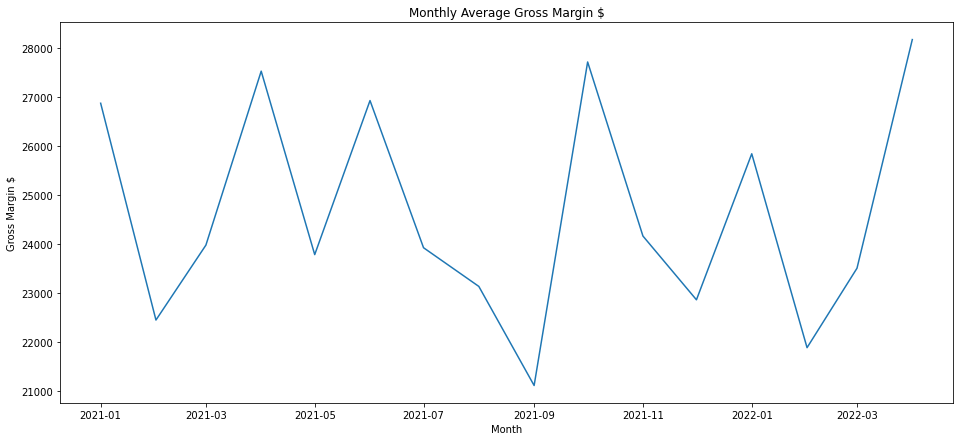

In [188]:
df_new_monthly_margin = pd.DataFrame(df_new.groupby('Month')['Gross Margin $'].mean())
plt.figure(figsize=(16,7))
sns.lineplot(x = df_new_monthly_margin.index, y = df_new_monthly_margin['Gross Margin $'])
plt.title('Monthly Average Gross Margin $')
plt.show()

In [189]:
df_new_monthly_margin[df_new_monthly_margin['Gross Margin $'] == df_new_monthly_margin['Gross Margin $'].max()]
# the best gross margin happened in April 2022.

,Gross Margin $
Month,
2022-04-01,28170.7475


In [190]:
df_new.query("Month =='2022-04-01'")

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
65,2022,14,Pantene,6.79,Yes,0.15,13118,89071.22,35287.42,12247,7.272901,2.881311,4.1,2022-04-04,2022-04-01
66,2022,15,Pantene,6.79,No,0.15,11477,77928.83,30873.13,10410,7.485959,2.965719,4.1,2022-04-11,2022-04-01
132,2022,14,Aussie,4.99,No,0.00,10767,53727.33,23579.73,10556,5.089743,2.233775,2.8,2022-04-04,2022-04-01
133,2022,15,Aussie,4.79,Yes,0.05,11529,55223.91,22942.71,11303,4.885775,2.029789,2.8,2022-04-11,2022-04-01


In [ ]:
# The maximum discount on Aussie in the month which has the highest margin is:
# Either no discount at $4.99 per bottle.  
# Or 5% discount at $4.79 per bottle.

In [191]:
df_Aussie_price_margin = pd.DataFrame(df_Aussie.groupby(['Discount','Price'])['Gross Margin $'].mean())
df_Aussie_price_margin2 = df_Aussie_price_margin.rename(columns ={'Gross Margin $':'Margin_avg'})
df_Aussie_price_margin3= df_Aussie_price_margin2.reset_index()
df_Aussie_price_margin3

,Discount,Price,Margin_avg
0,0.00,4.99,23891.465172
1,0.05,4.79,22942.710000
2,0.10,4.49,21339.947228
3,0.15,4.29,23264.139503
4,0.20,3.99,26653.322500
5,0.30,3.49,24598.193333
6,0.35,3.29,22778.980000
7,0.40,2.99,10847.733333
8,0.50,2.49,-23932.000000


Text(0.5, 1.0, 'Average Gross Margin of Aussie at different price')

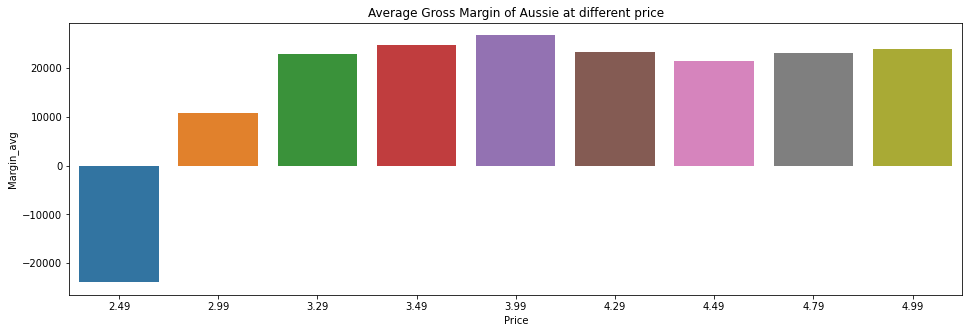

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=df_Aussie_price_margin3['Price'],y = 'Margin_avg', data = df_Aussie_price_margin3)
plt.title('Average Gross Margin of Aussie at different price')

###### Conclusion: The gross margin is the highest when Aussie is sold at 3.99 which is 20% discount.
When Aussie is sold at 2.99 which is 40% discount, it does not improve Margin.